# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

There are 37 unique campaigns in this data.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

In [100]:
bank_data = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [101]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [102]:
bank_data['campaign'].value_counts()

campaign
1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: count, dtype: int64

In [103]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [104]:
print(bank_data.shape)

(41188, 21)


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



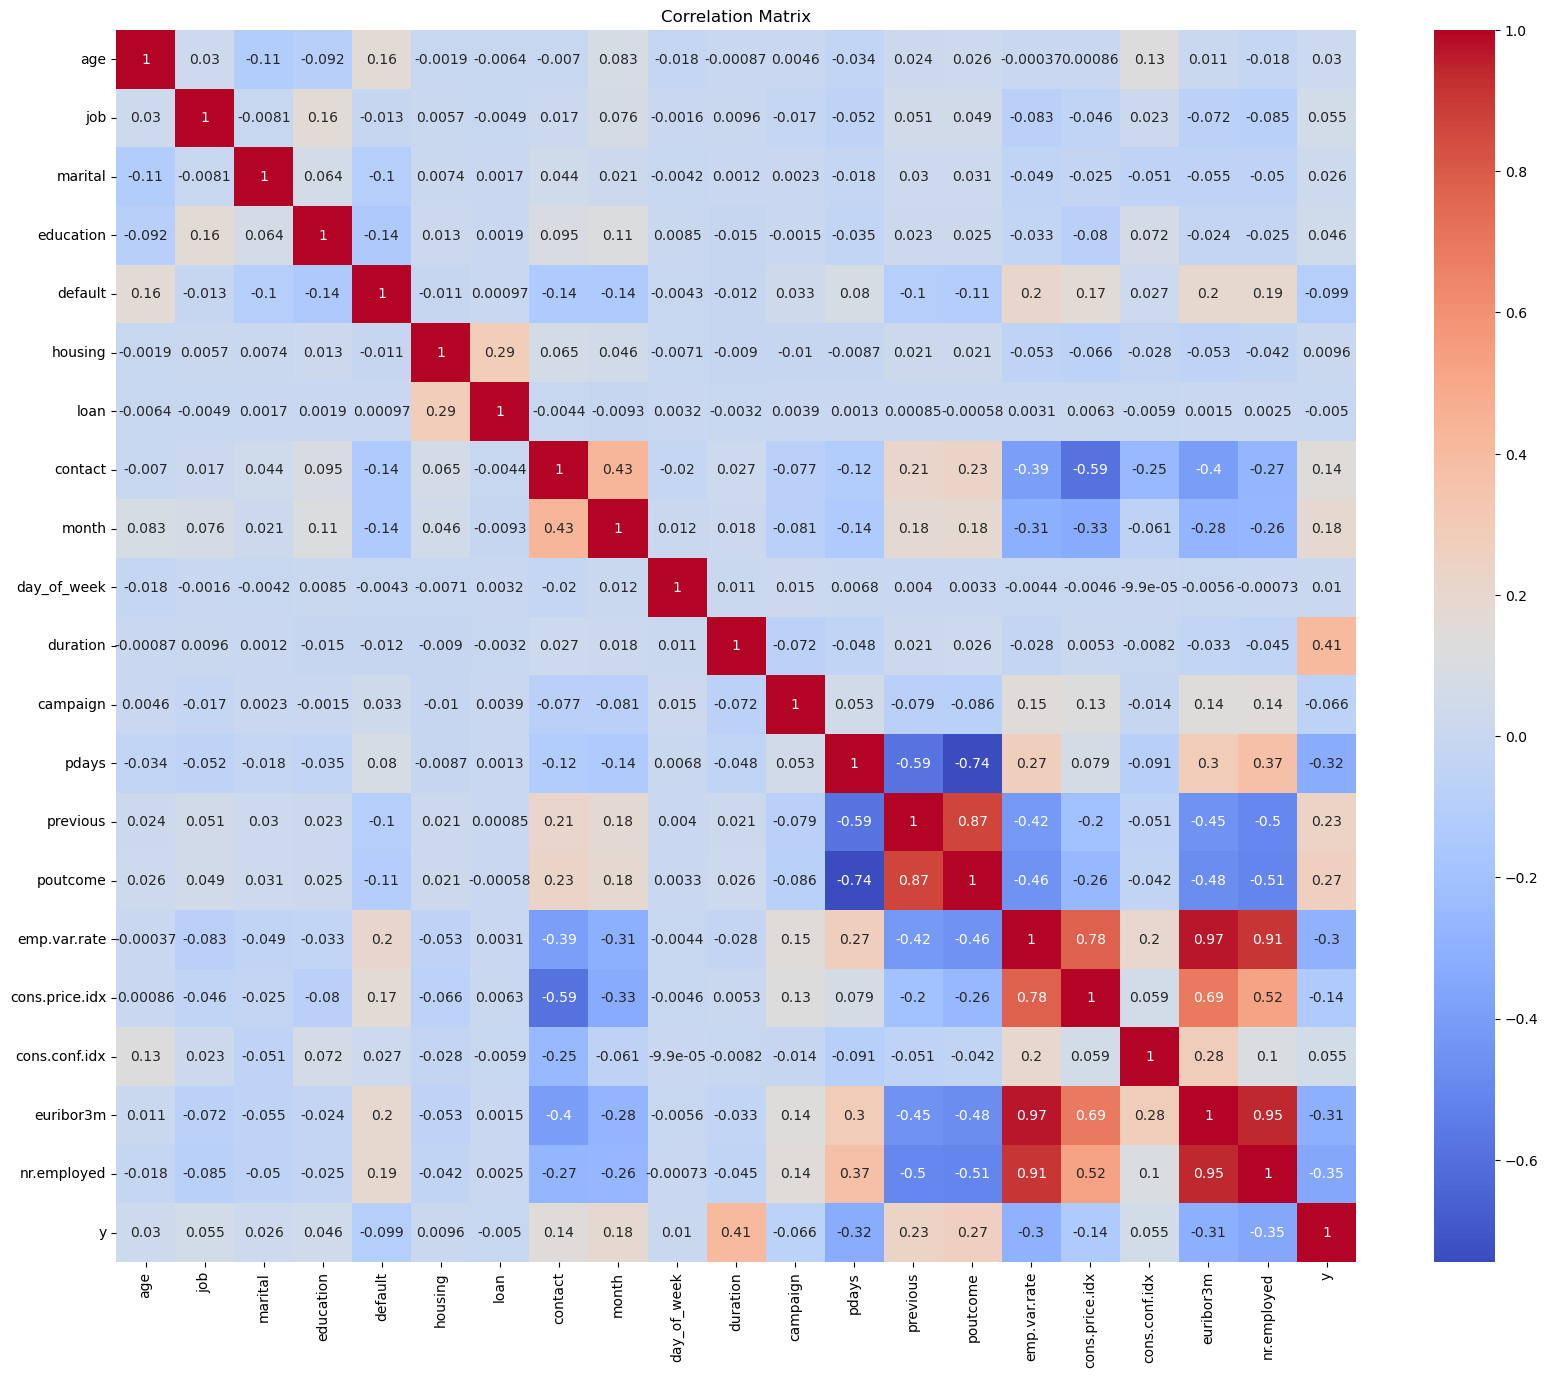

In [105]:
# Create a copy of the dataframe
bank_data_heatmap = bank_data.copy()

# Convert categorical columns to numeric columns
for col in bank_data_heatmap.select_dtypes(include='object').columns:
    bank_data_heatmap[col], _ = pd.factorize(bank_data_heatmap[col])

    # Compute the correlation matrix
corr_matrix = bank_data_heatmap.corr()

# Plot the heatmap matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

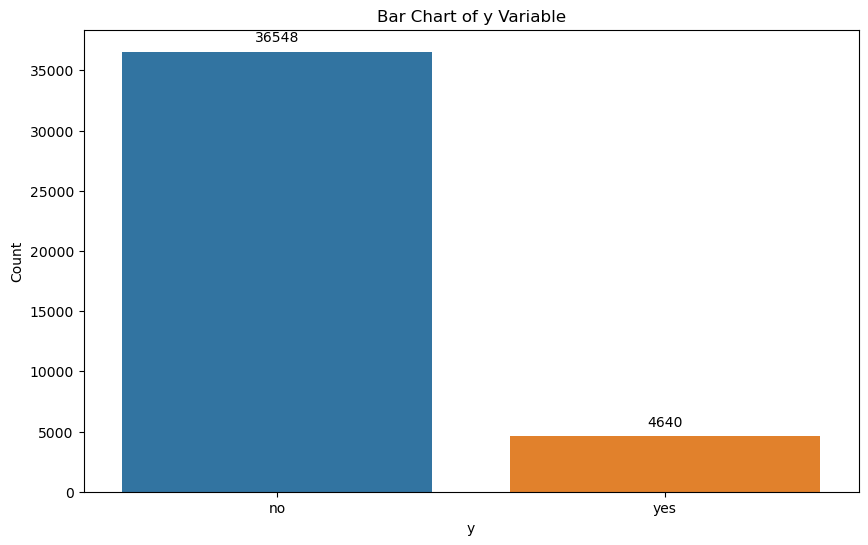

In [106]:
# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='y', data=bank_data)
plt.title('Bar Chart of y Variable')
plt.xlabel('y')
plt.ylabel('Count')

# Add count values on the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

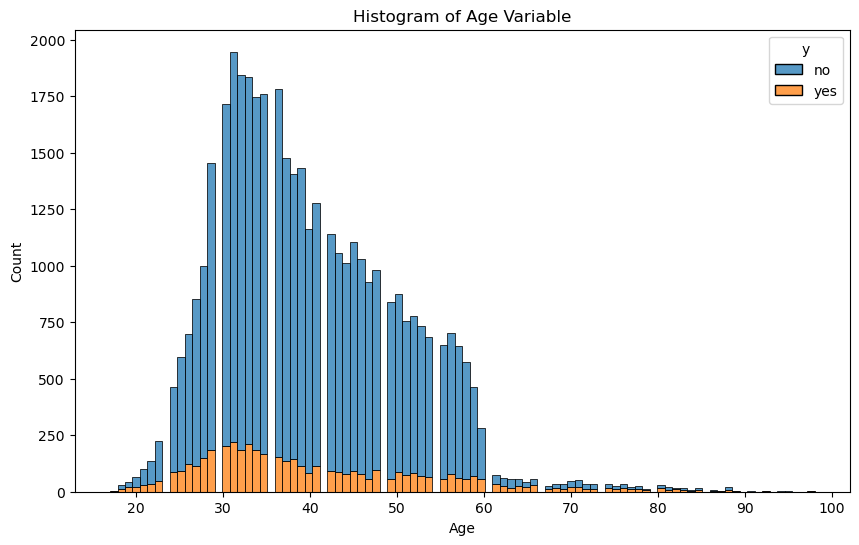

In [107]:
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=bank_data, hue='y', multiple='stack')
plt.title('Histogram of Age Variable')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

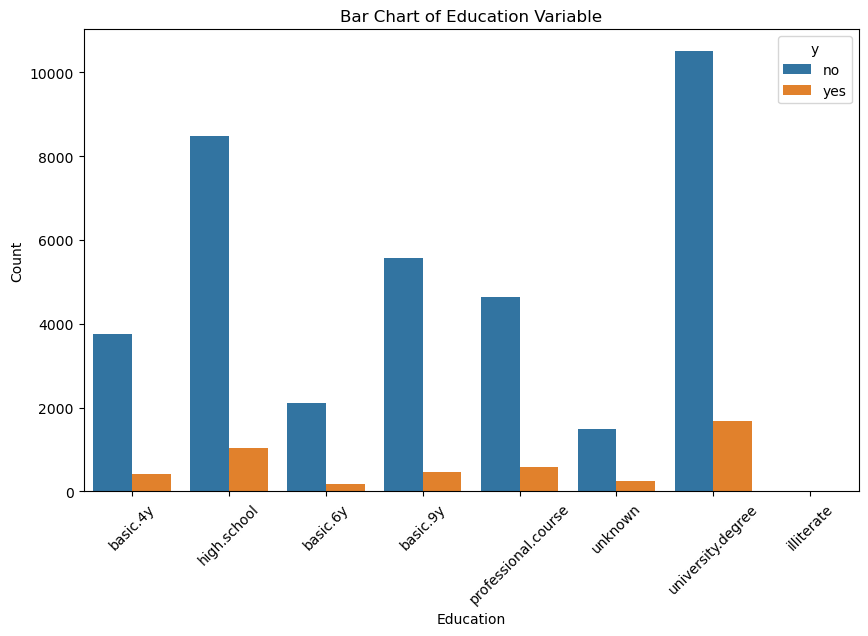

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='education', hue='y', data=bank_data)
plt.title('Bar Chart of Education Variable')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

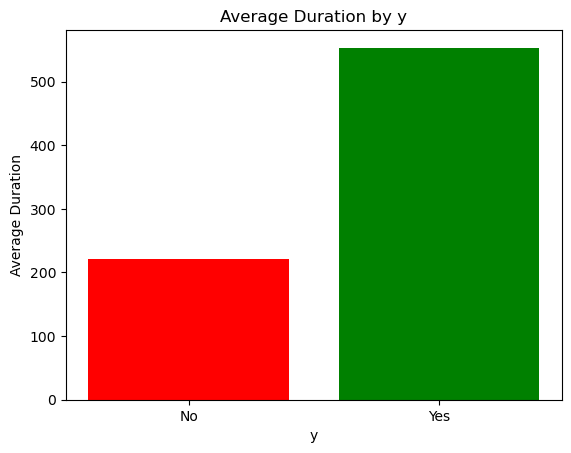

In [99]:
y_duration = bank_data.groupby('y')['duration'].mean()
plt.bar(y_duration.index, y_duration.values, color=['red', 'green'])
plt.title('Average Duration by y')
plt.xlabel('y')
plt.ylabel('Average Duration')
plt.xticks(np.arange(2), ['No', 'Yes'])
plt.show()

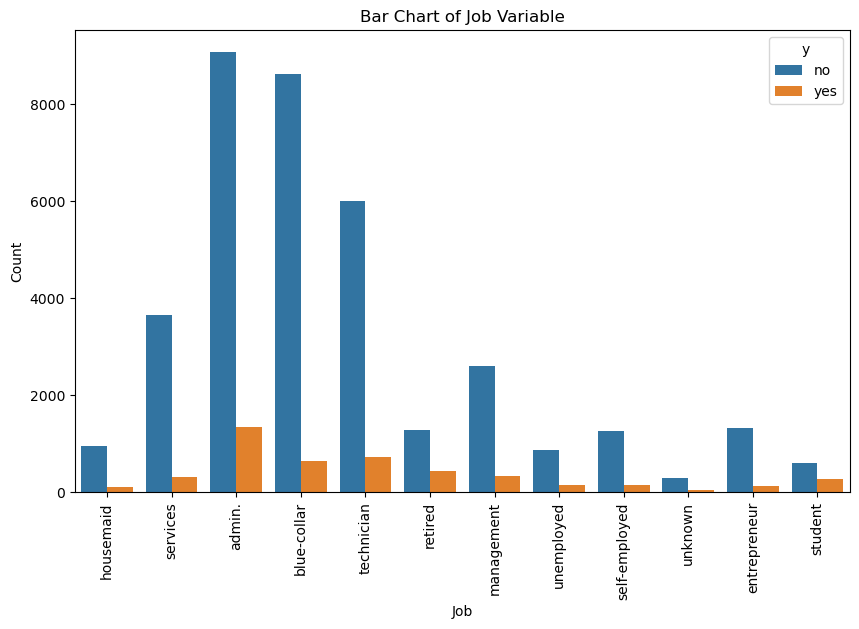

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(x='job', hue='y', data=bank_data)
plt.title('Bar Chart of Job Variable')
plt.xlabel('Job')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

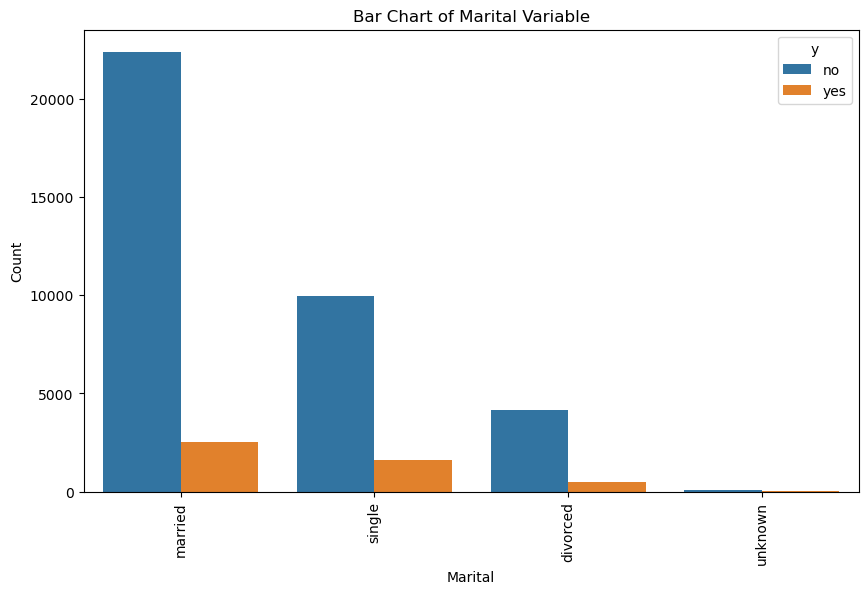

In [116]:
plt.figure(figsize=(10, 6))
sns.countplot(x='marital', hue='y', data=bank_data)
plt.title('Bar Chart of Marital Variable')
plt.xlabel('Marital')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

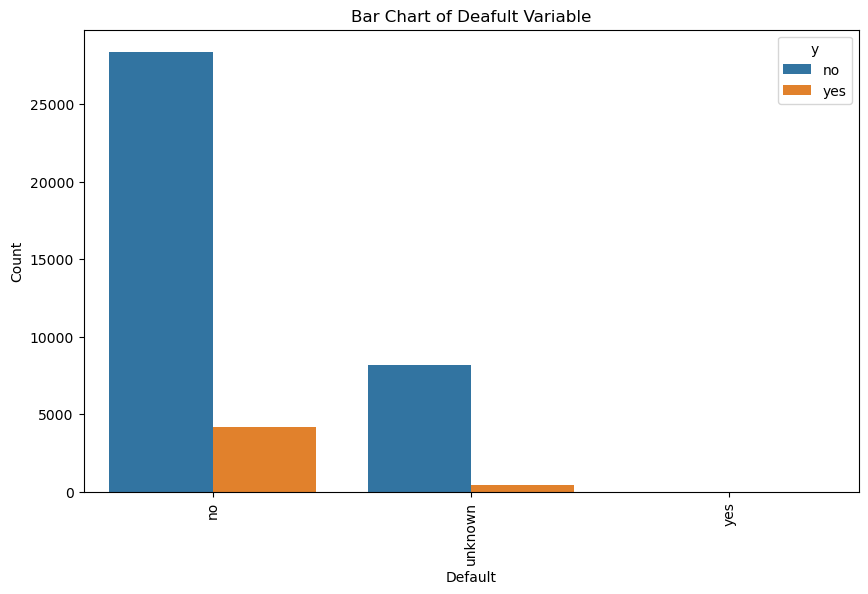

In [117]:
plt.figure(figsize=(10, 6))
sns.countplot(x='default', hue='y', data=bank_data)
plt.title('Bar Chart of Deafult Variable')
plt.xlabel('Default')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

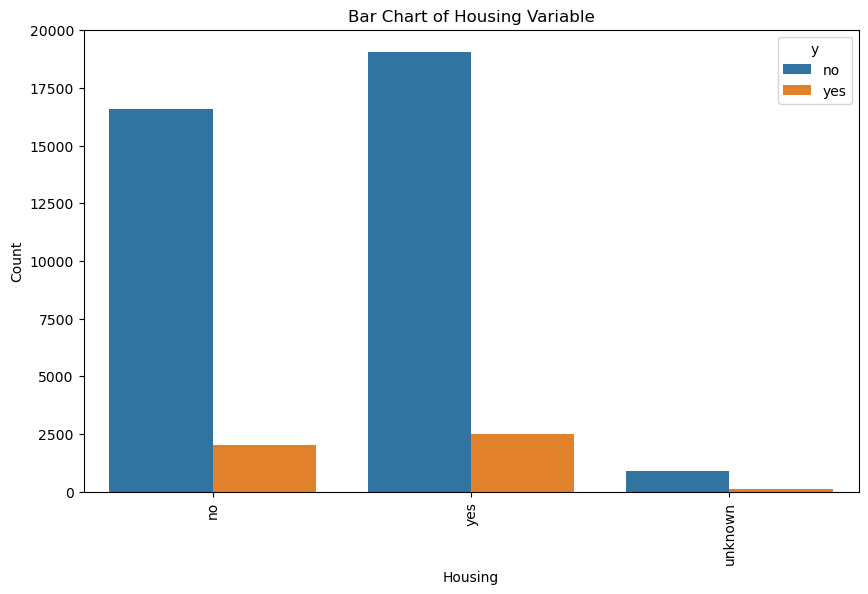

In [119]:
plt.figure(figsize=(10, 6))
sns.countplot(x='housing', hue='y', data=bank_data)
plt.title('Bar Chart of Housing Variable')
plt.xlabel('Housing')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

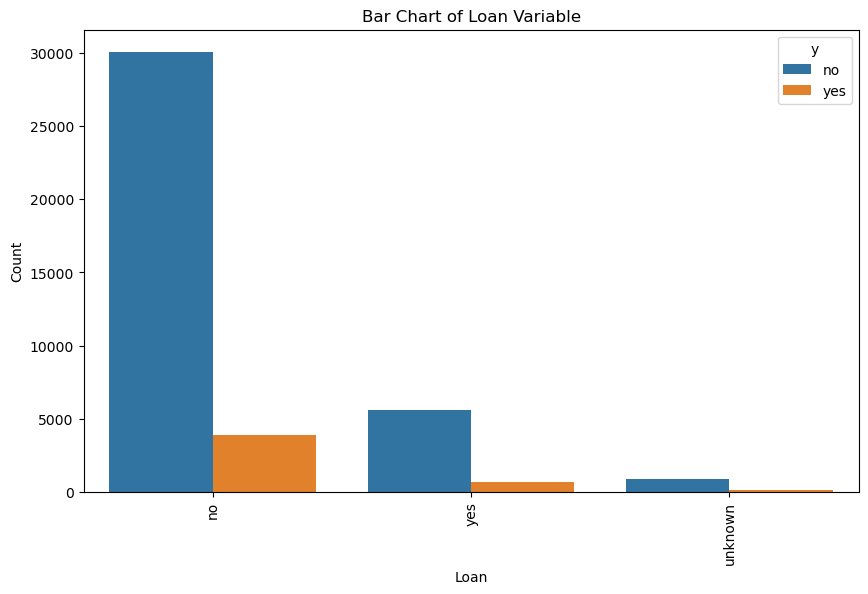

In [120]:
plt.figure(figsize=(10, 6))
sns.countplot(x='loan', hue='y', data=bank_data)
plt.title('Bar Chart of Loan Variable')
plt.xlabel('Loan')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

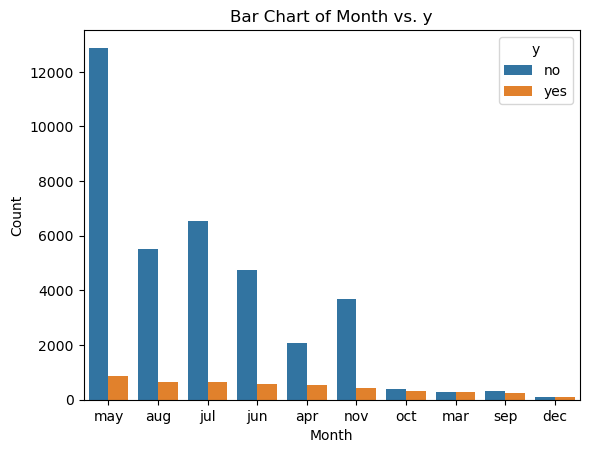

In [37]:
month_order = bank_data[bank_data['y'] == 'yes']['month'].value_counts().index

sns.countplot(x='month', hue='y', data=bank_data, order=month_order)
plt.title('Bar Chart of Month vs. y')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

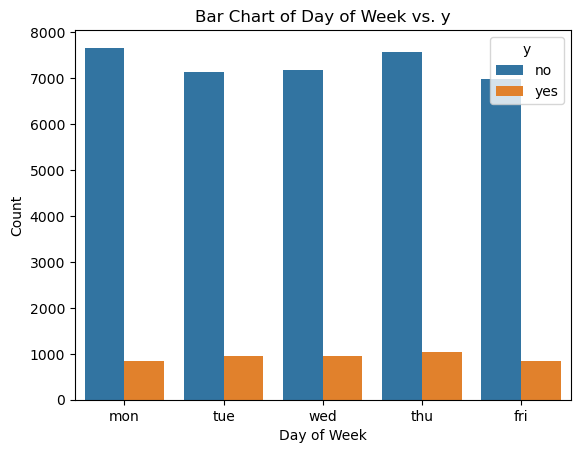

In [33]:
sns.countplot(x='day_of_week', hue='y', data=bank_data)
plt.title('Bar Chart of Day of Week vs. y')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

No missing values are present, and the correct data types are assigned.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [6]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [7]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [49]:
bank_data.columns[:7]

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')

In [131]:
bank_data[list(bank_data.columns)[:7]].head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


In [132]:
print(bank_data[bank_data.duplicated()])

       age          job   marital            education  default housing loan  \
1266    39  blue-collar   married             basic.6y       no      no   no   
12261   36      retired   married              unknown       no      no   no   
14234   27   technician    single  professional.course       no      no   no   
16956   47   technician  divorced          high.school       no     yes   no   
18465   32   technician    single  professional.course       no     yes   no   
20216   55     services   married          high.school  unknown      no   no   
20534   41   technician   married  professional.course       no     yes   no   
25217   39       admin.   married    university.degree       no      no   no   
28477   24     services    single          high.school       no     yes   no   
32516   35       admin.   married    university.degree       no     yes   no   
36951   45       admin.   married    university.degree       no      no   no   
38281   71      retired    single    uni

In [133]:
bank_data.duplicated().sum()


12

In [134]:
bank_data.drop_duplicates(inplace=True)


In [50]:
#Converting 'y' into numerical values for improved data manipulation.

y_categories={'yes':1,'no': 0} 

bank_data['y_category']=bank_data['y'].map(y_categories)

In [51]:
print(bank_data)

       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  ...  pdays  pre

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [52]:
bd= bank_data[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]

In [53]:
bd_copy=bd.copy(deep=True)

In [54]:
x_axis = bd
y_axis = bank_data['y_category']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(x_axis,y_axis, test_size=0.3, random_state=101,stratify=y_axis)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Multinomial

In [56]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']
numerical_features = ['age']

#MinMaxScaler to scale numerical features to a specific range (default is [0, 1]).

numeric_transformer = Pipeline(
    steps=[
        ("scaler", MinMaxScaler())]
)

#OneHotEncoder to convert categorical features into one-hot encoded vectors

categorical_transformer = OneHotEncoder(drop="if_binary")


preprocessor_minmax = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ])

In [108]:
Baseline_model= Pipeline([("preprocessor", preprocessor_minmax), ('Baseline',LogisticRegression(multi_class='multinomial'))])

In [109]:
Baseline_start_time= time.time()
Baseline_model.fit(X_train, y_train)
Baseline_end_time= time.time()
Baseline_train_time = Baseline_end_time-Baseline_start_time
print(Baseline_train_time)

0.2828798294067383


Calculate accurancy of the Baseline Model

In [59]:
# Make predictions on the training data
y_train_pred_baseline = Baseline_model.predict(X_train)

# Calculate training accuracy
accuracy_train_baseline = accuracy_score(y_train, y_train_pred_baseline)
print(f'Baseline Model Training Accuracy: {accuracy_train_baseline:.2%}')

# Make predictions on the test data
y_test_pred_baseline = Baseline_model.predict(X_test)

# Calculate test accuracy
accuracy_test_baseline = accuracy_score(y_test, y_test_pred_baseline)
print(f'Baseline Model Test Accuracy: {accuracy_test_baseline:.2%}')

# Additional evaluation metrics for the test set
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_baseline))

Baseline Model Training Accuracy: 88.74%
Baseline Model Test Accuracy: 88.73%
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10965
           1       0.00      0.00      0.00      1392

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.79      0.89      0.83     12357



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [60]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = Pipeline([
    ("preprocessor", preprocessor_minmax),
    ('LogisticRegression', LogisticRegression(max_iter=1000,random_state=42))
])


In [61]:
logistic_start_time=time.time()
logistic_regression_model.fit(X_train, y_train)
logistic_end_time=time.time()
logistic_train_time = logistic_end_time-logistic_start_time
print(logistic_train_time)

0.185791015625


### Problem 9: Score the Model

What is the accuracy of your model?

In [62]:
# Make predictions on the training data
y_train_pred = logistic_regression_model.predict(X_train)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy:.2%}')

# Make predictions on the test data
y_test_pred = logistic_regression_model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2%}')

print(classification_report(y_test, y_test_pred, zero_division=1))

Training Accuracy: 88.73%
Test Accuracy: 88.74%
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10965
           1       1.00      0.00      0.00      1392

    accuracy                           0.89     12357
   macro avg       0.94      0.50      0.47     12357
weighted avg       0.90      0.89      0.83     12357



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

K Nearest Neighbour

In [70]:
from sklearn.neighbors import KNeighborsClassifier


# Standardize numerical features using StandardScaler
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_pipeline = Pipeline([
    ("preprocessor", preprocessor_minmax),
    ("KNN", knn_model)
])

# Train the KNN model
knn_start_time= time.time()
knn_pipeline.fit(X_train, y_train)
knn_end_time=time.time()
knn_train_time=knn_end_time-knn_start_time

print(knn_train_time)

# Make predictions on the training data
y_train_pred_knn = knn_pipeline.predict(X_train)

# Calculate training accuracy
accuracy_train_knn = accuracy_score(y_train, y_train_pred_knn)
print(f'KNN Model Training Accuracy: {accuracy_train_knn:.2%}')

# Make predictions on the test data
y_test_pred_knn = knn_pipeline.predict(X_test)

# Calculate and print the test accuracy
accuracy_test_knn = accuracy_score(y_test, y_test_pred_knn)
print(f'KNN Model Test Accuracy: {accuracy_test_knn:.2%}')

# Additional evaluation metrics for the test set
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_knn))


0.059140920639038086
KNN Model Training Accuracy: 89.17%
KNN Model Test Accuracy: 87.63%
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     10965
           1       0.28      0.06      0.10      1392

    accuracy                           0.88     12357
   macro avg       0.59      0.52      0.52     12357
weighted avg       0.82      0.88      0.84     12357



Decision Tree Classifier

In [64]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']


#OneHotEncoder to convert categorical features into one-hot encoded vectors

categorical_transformer = OneHotEncoder(drop="if_binary")


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
    ])

In [75]:
from sklearn.tree import DecisionTreeClassifier

# Create a pipeline with preprocessing and Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)
dt_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("DecisionTree", decision_tree_model)
])

# Train the Decision Tree model

decision_tree_start_time = time.time()
dt_pipeline.fit(X_train, y_train)
decision_tree_end_time = time.time()
decision_tree_train_time = decision_tree_end_time - decision_tree_start_time

print(f'Decision Tree train time: {decision_tree_train_time}')

# Make predictions on the training data
y_train_pred_decision_tree = dt_pipeline.predict(X_train)

# Calculate and print the training accuracy
accuracy_train_decision_tree = accuracy_score(y_train, y_train_pred_decision_tree)
print(f'Decision Tree Model Training Accuracy: {accuracy_train_decision_tree:.2%}')

# Make predictions on the test data
y_pred_decision_tree = dt_pipeline.predict(X_test)

# Calculate and print the test accuracy
accuracy_test_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print(f'Decision Tree Model Test Accuracy: {accuracy_test_decision_tree:.2%}')

print(classification_report(y_test, y_pred_decision_tree))

Decision Tree train time: 0.09976816177368164
Decision Tree Model Training Accuracy: 88.97%
Decision Tree Model Test Accuracy: 88.43%
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10965
           1       0.13      0.01      0.01      1392

    accuracy                           0.88     12357
   macro avg       0.51      0.50      0.47     12357
weighted avg       0.80      0.88      0.83     12357



Support Vector Machine

In [78]:
from sklearn.svm import SVC

SVM_default= Pipeline(
    steps=[("preprocessor", preprocessor_minmax), ('SVC',SVC(probability=True, kernel='rbf'))]
)

# Train the SVM_default model and measure the time
start_time = time.time()
SVM_default.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

# Make predictions on the training data
y_train_pred_svm_default = SVM_default.predict(X_train)

# Calculate and print the training accuracy
train_accuracy_svm_default = accuracy_score(y_train, y_train_pred_svm_default)
print(f'SVM Default Model Training Accuracy: {train_accuracy_svm_default:.2%}')

# Make predictions on the test data
y_test_pred_svm_default = SVM_default.predict(X_test)

# Calculate and print the test accuracy
test_accuracy_svm_default = accuracy_score(y_test, y_test_pred_svm_default)
print(f'SVM Default Model Test Accuracy: {test_accuracy_svm_default:.2%}')

# Additional evaluation metrics for the test set
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_svm_default, zero_division=1))

# Print the training time
print(f'Training Time: {train_time:.4f} seconds')


SVM Default Model Training Accuracy: 88.73%
SVM Default Model Test Accuracy: 88.74%
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10965
           1       1.00      0.00      0.00      1392

    accuracy                           0.89     12357
   macro avg       0.94      0.50      0.47     12357
weighted avg       0.90      0.89      0.83     12357

Training Time: 64.5441 seconds


In [113]:
results_df = pd.DataFrame({
    'Model': ['Baseline Model' ,'Logistic Regression', 'K Nearest Neighbour', 'Decision Tree', 'Support Vector Machine'],
    'Train Time': [Baseline_train_time, logistic_train_time, knn_train_time, decision_tree_train_time, train_time],
    'Train Accuracy': [accuracy_train_baseline, train_accuracy, accuracy_train_knn, accuracy_train_decision_tree, train_accuracy_svm_default],
    'Test Accuracy': [accuracy_test_baseline, test_accuracy, accuracy_test_knn, accuracy_test_decision_tree, test_accuracy_svm_default]
})

In [114]:
print(results_df)

                    Model  Train Time  Train Accuracy  Test Accuracy
0          Baseline Model    0.282880        0.887378       0.887270
1     Logistic Regression    0.163853        0.887343       0.887351
2     K Nearest Neighbour    0.059141        0.891748       0.876345
3           Decision Tree    0.099768        0.889702       0.884276
4  Support Vector Machine   64.544134        0.887343       0.887351


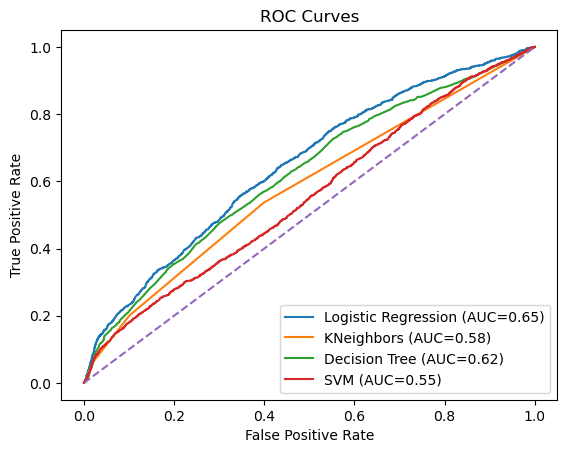

In [81]:
# Predict probabilities for the testing data
y_pred_proba_lr = logistic_regression_model.predict_proba(X_test)[:, 1]
y_pred_proba_dt = dt_pipeline.predict_proba(X_test)[:,1]
y_pred_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]
y_pred_proba_svm = SVM_default.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC score for each model
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
auc_score_lr = roc_auc_score(y_test, y_pred_proba_lr)

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
auc_score_dt = roc_auc_score(y_test, y_pred_proba_dt)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn)
auc_score_knn = roc_auc_score(y_test, y_pred_proba_knn)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_proba_svm)
auc_score_svm = roc_auc_score(y_test, y_pred_proba_svm)

# Plot ROC curves for each model
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_score_lr:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNeighbors (AUC={auc_score_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={auc_score_dt:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC={auc_score_svm:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [148]:
# Load the data into a pandas dataframe
bank_data = pd.read_csv('data/bank-additional-full.csv', sep = ';')

# Create a new dataframe with a subset of columns
df_bank_data = bank_data.loc[:, ['job', 'marital', 'education', 'default', 'housing', 'loan', 'y']]

# Print the info of the new dataframe
df_bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job        41188 non-null  object
 1   marital    41188 non-null  object
 2   education  41188 non-null  object
 3   default    41188 non-null  object
 4   housing    41188 non-null  object
 5   loan       41188 non-null  object
 6   y          41188 non-null  object
dtypes: object(7)
memory usage: 2.2+ MB


In [149]:
# Encode the categorical variables using one-hot encoding
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan']
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df_bank_data[cat_vars]).toarray()
encoded_data = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_vars))
df_bank_data = pd.concat([df_bank_data.drop(cat_vars, axis=1), encoded_data], axis=1)

In [150]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_bank_data.drop('y', axis=1), df_bank_data['y'], test_size=0.2, random_state=42)

In [153]:
# Define the models and their hyperparameters for the grid search
models = {
    #'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [3, 5, 7]}),
    'Logistic Regression': (LogisticRegression(), {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']})
}

In [174]:
# Perform grid search for each model and print results
for name, (model, params) in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    grid_search = GridSearchCV(model, params, cv=5)
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.3f}s")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Training accuracy: {grid_search.best_score_:.3f}")
    print(f"Test accuracy: {grid_search.score(X_test, y_test):.3f}")
    print(f"Precision Score: {precision_score(y_test, y_pred, pos_label = 'yes')}")
    print(f"Recall Score: {recall_score(y_test, y_pred, pos_label = 'yes')}")
    print(f"F1 Score: {f1_score(y_test, y_pred, pos_label = 'yes')}")
    print()

Training SVM...
Training time: 172.448s
Best parameters: {'C': 0.1, 'kernel': 'linear'}
Training accuracy: 0.888
Test accuracy: 0.887
Precision Score: 0.4583333333333333
Recall Score: 0.023529411764705882
F1 Score: 0.04476093591047813

Training Decision Tree...
Training time: 0.595s
Best parameters: {'max_depth': 3}
Training accuracy: 0.888
Test accuracy: 0.887
Precision Score: 0.4583333333333333
Recall Score: 0.023529411764705882
F1 Score: 0.04476093591047813

Training Logistic Regression...
Training time: 2.971s
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Training accuracy: 0.888
Test accuracy: 0.887
Precision Score: 0.4583333333333333
Recall Score: 0.023529411764705882
F1 Score: 0.04476093591047813



In [173]:
# KNN

knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=10))])
knn_pipe

params = {'knn__n_neighbors': list(range(1, 22, 2))}

knn_grid = GridSearchCV(knn_pipe, param_grid=params)

print(f"Training KNeighbor ...")
start_time = time.time()

knn_grid.fit(X_train, y_train)

end_time = time.time()

print(f"Training time: {end_time - start_time:.3f}s")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Training accuracy: {grid_search.best_score_:.3f}")
print(f"Test accuracy: {grid_search.score(X_test, y_test):.3f}")
print(f"Precision Score: {precision_score(y_test, y_pred, pos_label = 'yes')}")
print(f"Recall Score: {recall_score(y_test, y_pred, pos_label = 'yes')}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label = 'yes')}")
print()

Training KNeighbor ...
Training time: 15.453s
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Training accuracy: 0.888
Test accuracy: 0.887
Precision Score: 0.4583333333333333
Recall Score: 0.023529411764705882
F1 Score: 0.04476093591047813



##### Questions